## Import libraries and such

In [325]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load in an iris image and test Daugmans integro-differential operator

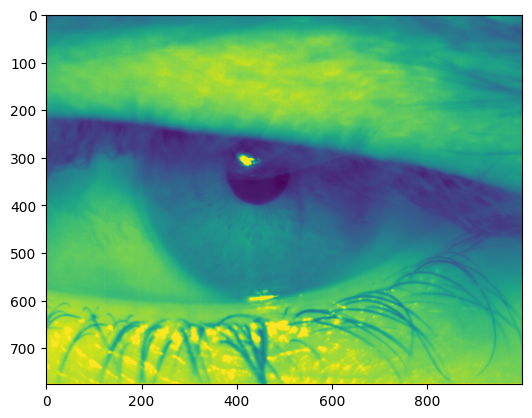

(776, 1000, 3)
0.0


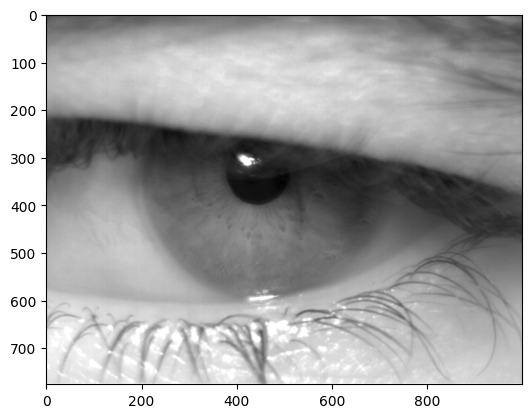

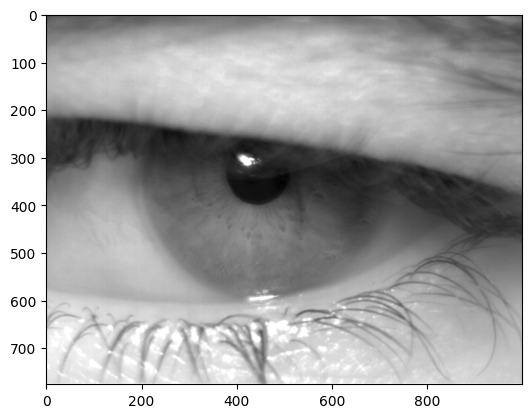

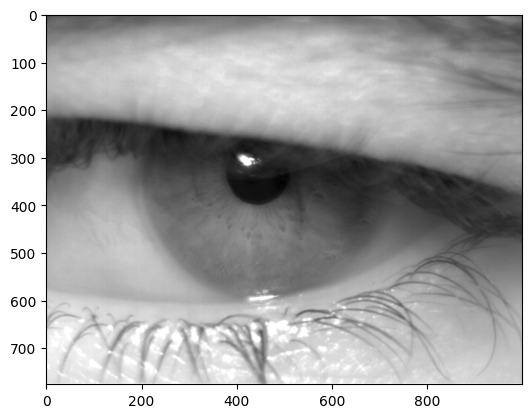

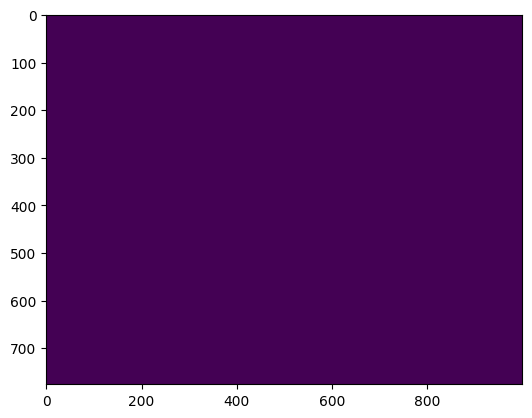

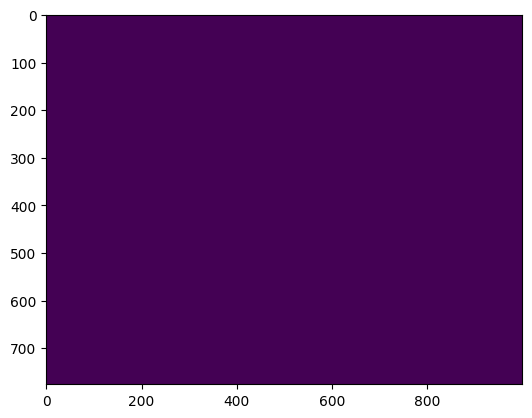

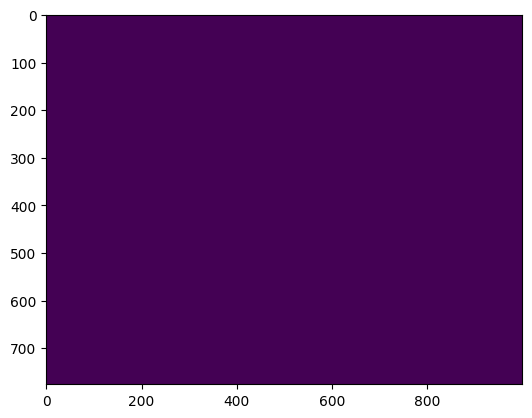

In [184]:
#img = cv2.imread("MMU-Iris-Database/1/left/aeval1.bmp").astype(np.double) / 255
img = cv2.imread("UTIRIS_infrared/001/001_L/Img_001_L_1_1.bmp").astype(np.double) / 255
img2 = cv2.cvtColor(cv2.imread("UTIRIS_infrared/001/001_L/Img_001_L_1_1.bmp"), cv2.COLOR_BGR2GRAY)
plt.imshow(img2)
plt.show()
print(img.shape)
print((np.abs(img[:, :, 2] - img[:, :, 1])).sum())
plt.imshow(img[:, :, 0], cmap="gray")
plt.show()
plt.imshow(img[:, :, 1], cmap="gray")
plt.show()
plt.imshow(img[:, :, 2], cmap="gray")
plt.show()
plt.imshow(img[:, :, 2] - img[:, :, 1])
plt.show()
plt.imshow(img[:, :, 0] - img[:, :, 1])
plt.show()
plt.imshow(img[:, :, 0] - img[:, :, 2])
plt.show()

## Rename the data to be easier accessible

['MMU-Iris-Database/1', 'MMU-Iris-Database/10', 'MMU-Iris-Database/10_left_1', 'MMU-Iris-Database/10_left_2', 'MMU-Iris-Database/10_left_3', 'MMU-Iris-Database/10_left_4', 'MMU-Iris-Database/10_left_5', 'MMU-Iris-Database/10_right_1', 'MMU-Iris-Database/10_right_2', 'MMU-Iris-Database/10_right_3', 'MMU-Iris-Database/10_right_4', 'MMU-Iris-Database/10_right_5', 'MMU-Iris-Database/11', 'MMU-Iris-Database/11_left_1', 'MMU-Iris-Database/11_left_2', 'MMU-Iris-Database/11_left_3', 'MMU-Iris-Database/11_left_4', 'MMU-Iris-Database/11_left_5', 'MMU-Iris-Database/11_right_1', 'MMU-Iris-Database/11_right_2', 'MMU-Iris-Database/11_right_3', 'MMU-Iris-Database/11_right_4', 'MMU-Iris-Database/11_right_5', 'MMU-Iris-Database/12', 'MMU-Iris-Database/12_left_1', 'MMU-Iris-Database/12_left_2', 'MMU-Iris-Database/12_left_3', 'MMU-Iris-Database/12_left_4', 'MMU-Iris-Database/12_left_5', 'MMU-Iris-Database/12_right_1', 'MMU-Iris-Database/12_right_2', 'MMU-Iris-Database/12_right_3', 'MMU-Iris-Database/12_r

### Daugmans integro-differential operator

153.5 58.5
Estimated pupil radius:  147
Estimated pupil center:  [335, 661]
Optimal location and radius:  
x=654.0
y=315.0
r=159.0
Estimated iris radius:  268
Optimal location and radius:  
x=653.0
y=305.0
r=268.0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


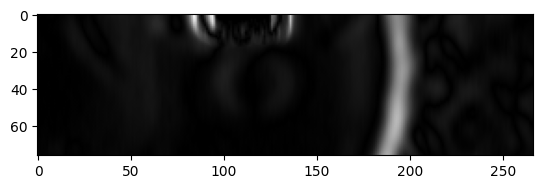

dist right:  202.0


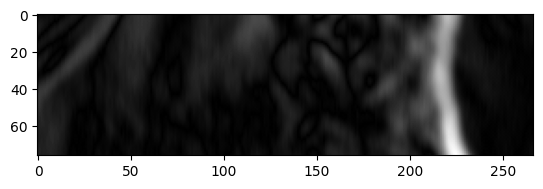

dist left:  48.0
dist left:  48.0


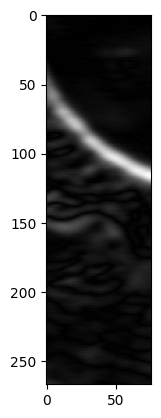

dist top:  104.0


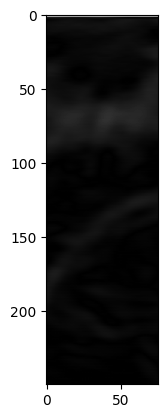

dist bottom:  181.5


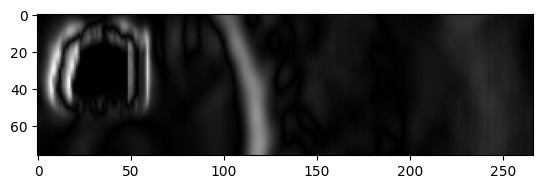

dist right:  60.0


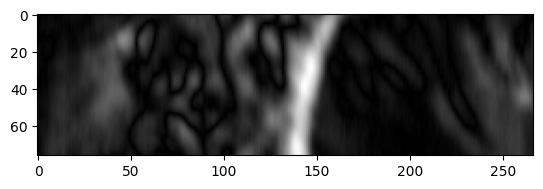

dist left:  123.0


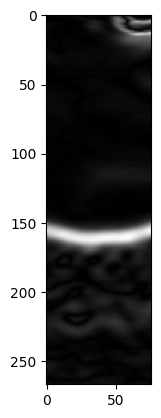

dist top:  169.0


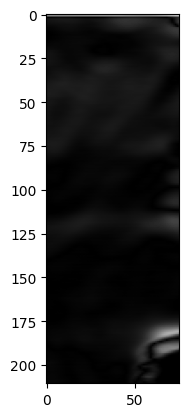

dist bottom:  168.0


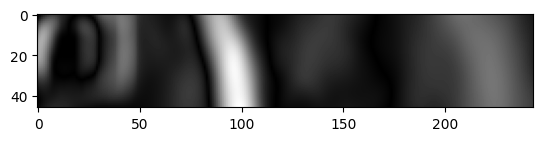

102.0 102.0


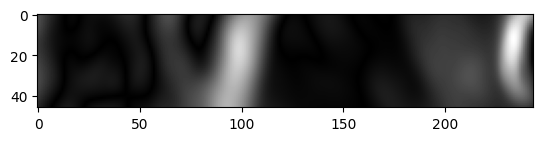

23.0 239.0
Estimated pupil radius:  62
Estimated pupil center:  [257, 431]
Optimal location and radius:  
x=413.0
y=246.0
r=52.0
Estimated iris radius:  152
Optimal location and radius:  
x=405.0
y=249.0
r=156.0


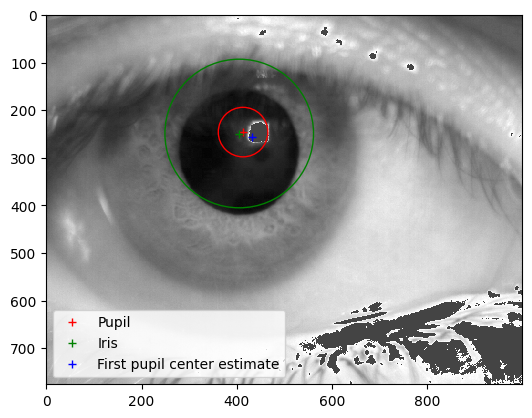

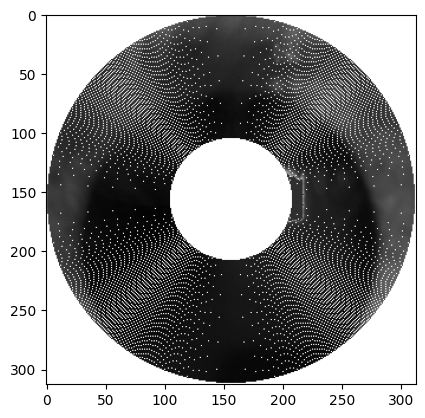

In [579]:
from IrisSegmentation import FindPupilIris, LocateEyelids, LocateEyelids2, EyelidFitter
%load_ext autoreload
%autoreload 2

img_use = cv2.imread("UTIRIS_infrared/021/021_L/Img_021_L_5.bmp").astype(np.double)[: , :, 0] / 255
img_use = cv2.imread("UTIRIS_infrared/019/019_L/Img_019_L_1.bmp").astype(np.double)[: , :, 0] / 255
img_use = cv2.imread("UTIRIS_infrared/078/078_L/Img_078_L_5_1.bmp").astype(np.double)[: , :, 0] / 255
#img_use = cv2.imread("UTIRIS_infrared/060/060_R/Img_060_R_2_1.bmp").astype(np.double)[: , :, 0] / 255
img_use = cv2.imread("UTIRIS_infrared/075/075_R/Img_075_R_4_1.bmp").astype(np.double)[: , :, 0] / 255
#plt.imshow(img_use, cmap="gray")
#plt.show()
"""
Estimated pupil radius:  128
Estimated pupil center:  [282, 634]
Optimal location and radius:  
x=629.0
y=262.0
r=124.0
Estimated iris radius:  286
Optimal location and radius:  
x=639.0
y=253.0
r=294.0
"""
#EyelidFitter(r=286, x0=639, y0=253, pupil_radius=128, img=img_use)
FindPupilIris(img_use, filter_size=3, sigma=1.0, lateral=True, plot_img=None)
#Optimal location and radius:  
#x=592.0
#y=333.0
#r=267.0
#LocateEyelids(
#    r=267,
#    x0=592,
#    pupil_radius=30,
#    y0=333,
#    img=img_use
#)